In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display_html, display, Math, HTML

# Comparison

```{margin}
These sections continue to draw on [Think Bayes](https://greenteapress.com/wp/think-bayes) by Allen B. Downey.
```

Today we'll expand our Bayesian anaylsis toolkit by considering **joint distributions.**

## How Tall Is A?

Suppose we choose two people from the population of adult males in the U.S.; let's call them person A and person B. If we see that A is taller than B, how tall is A?

```{margin} 
Image credit: Stable Diffusion, prompt: "Photorealistic tall person and short person"
```

<center>
    
<img src="images/Stable-Diffusion-photorealistic-tall-person-and-short-person.jpg" width="200px">
    
</center>

At first glance this question might seem impossible. But by using everything we know about Bayesian statistics, combined with what we know about joint distrubtions, marginals, and conditional probabilities, we can actually come up with a reasonable anwer.

### Approaching the problem

1: Establish a prior for A's height:  we can use background information about the height of men in the U.S.

2: Construct a joint prior distribution of height for A and B

3: Update the prior with the information that A is taller

4: From the joint posterior distribution extract the posterior distribution of height for A.

### The Prior

In the U.S. the average height of male adults is 178 cm and the standard deviation is 7.7 cm and is approximately normal. 

We can use that as the prior distribution for the heights of both person A and B.

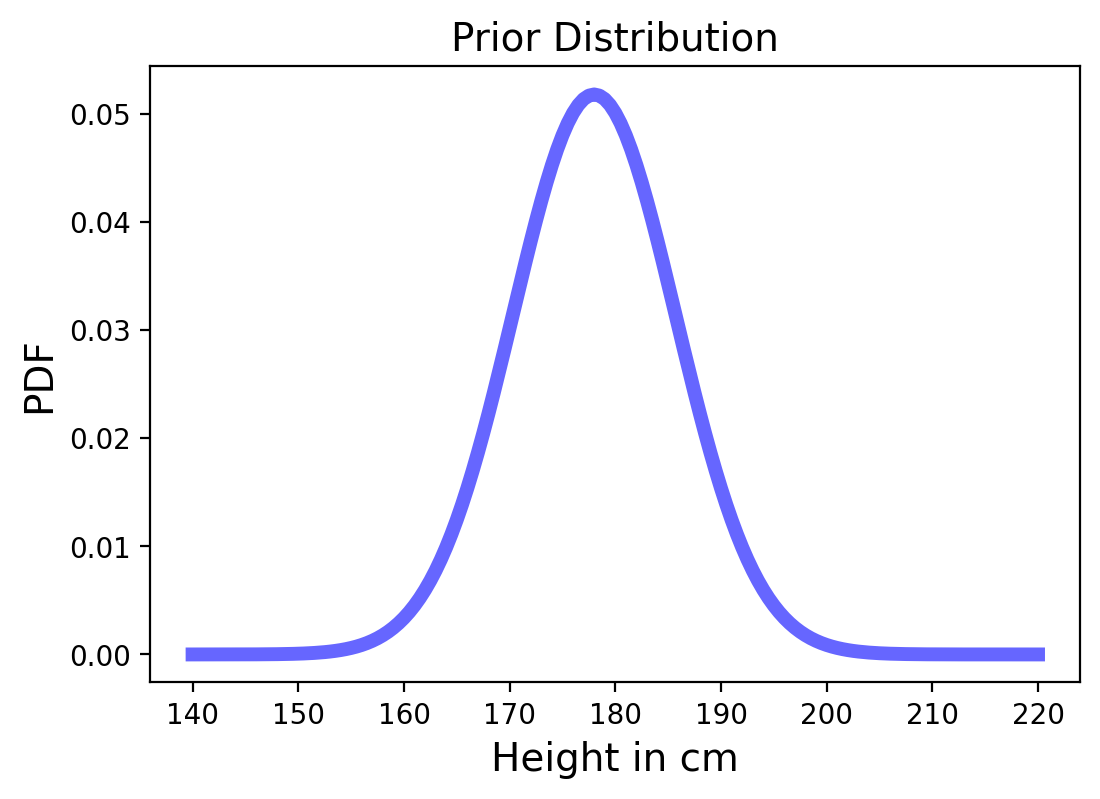

In [16]:
from scipy.stats import norm
plt.figure(figsize=(6, 4))
x = np.linspace(140,220, 161)
plt.plot(x, norm.pdf(x, 178, 7.7),'b-', lw = 5, alpha = 0.6)
plt.title('Prior Distribution', size=14)
plt.xlabel('Height in cm', size=14)
plt.ylabel('PDF', size=14);

### Joint Distribution of Heights

Next we want to construct the joint distirbution of heights for person A and B, which is just the probability of every pair of heights x and y.

$$ P(A_x,B_y) $$


For our prior we don't assume anything about how tall A and B are relative to each other. In other words we can assume their heights are independent. As we know, for independent random variables:

$$ P(A_x,B_y) = P(A_x)P(B_y)$$


So we just need to make a grid of probabilities where we multiply each pair of individual probabilities.

In [3]:
# multiplies prbabilities from two distributions
def make_joint(pmf1, pmf2):
    """Compute the outer product of two Pmfs."""
    X, Y = np.meshgrid(pmf1['probs'], pmf2['probs'])
    return pd.DataFrame(X * Y, columns=pmf1.index, index=pmf2.index)

# normal prior
p_dist = pd.DataFrame(index = np.linspace(140,220,161))
p_dist['probs'] = [norm.pdf(x, 178, 7.7) for x in p_dist.index]
p_dist['probs'] = p_dist['probs']/sum(p_dist['probs'])

# joint prior
joint = make_joint(p_dist, p_dist)

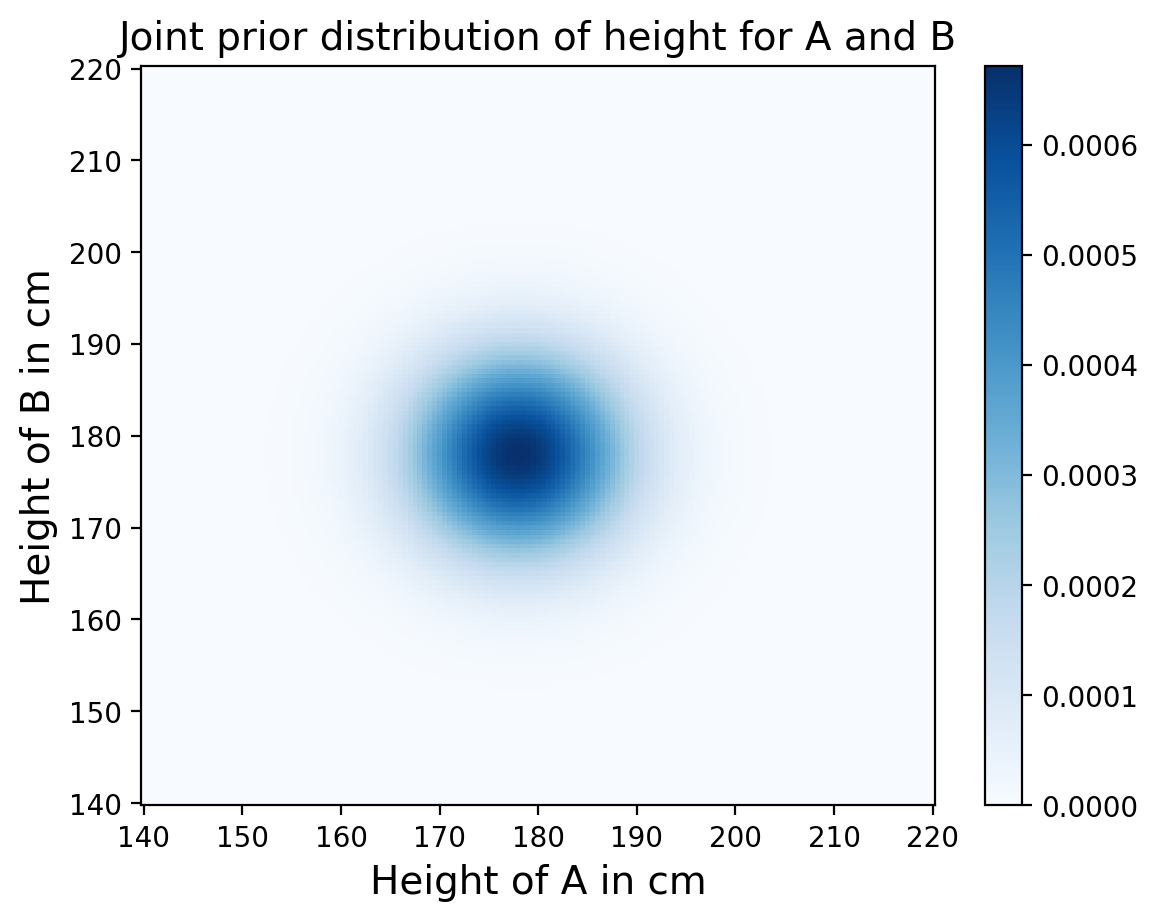

In [4]:
plt.pcolormesh(joint.columns, joint.index, joint, cmap='Blues')
plt.colorbar()
plt.xlabel('Height of A in cm', size=14)
plt.ylabel('Height of B in cm', size=14)
plt.title('Joint prior distribution of height for A and B', size=14);

### Joint Likelihood

Now that we have a joint prior distribution, we can update it with the data, which is that person A is taller than B.

Each element in the joint distribution represents a hypothesis about the heights of person A and B. 

We know that A is taller, so the likelhood of each hypothesis where B is taller is 0, and the likelihood of each hypothesis were A is taller is 1.

In [5]:
# create a grid of heights of A and heights of B
A, B = np.meshgrid(joint.columns, joint.index)

# check if A is taller (and add 0 to make it numeric)
A_taller = (A > B)+0
likelihood = pd.DataFrame(A_taller, index=joint.columns, columns=joint.index)

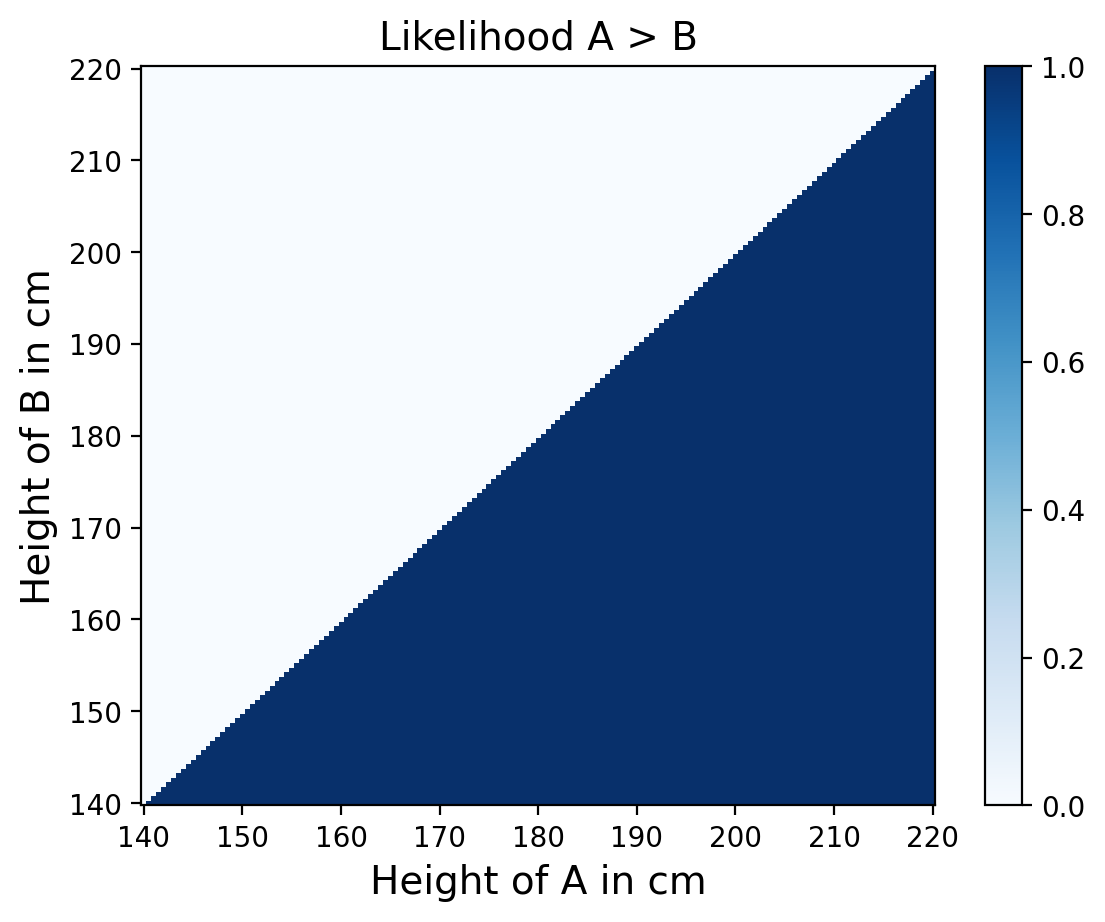

In [6]:
plt.pcolormesh(likelihood.columns, likelihood.index, likelihood, cmap='Blues')
plt.colorbar()
plt.xlabel('Height of A in cm', size=14)
plt.ylabel('Height of B in cm', size=14)
plt.title('Likelihood A > B', size=14);

### The Update

Like usual, the update is pretty simple, the posterier is still just the (joint) prior times the (joint) likelihood.


In [7]:
posterior = joint * likelihood

We do need to make a slight adjustment for normalizaion, where we need to divide over the sum of the whole grid of posterior probabilities.

In [8]:
prob_data = posterior.to_numpy().sum()
posterior = posterior / prob_data

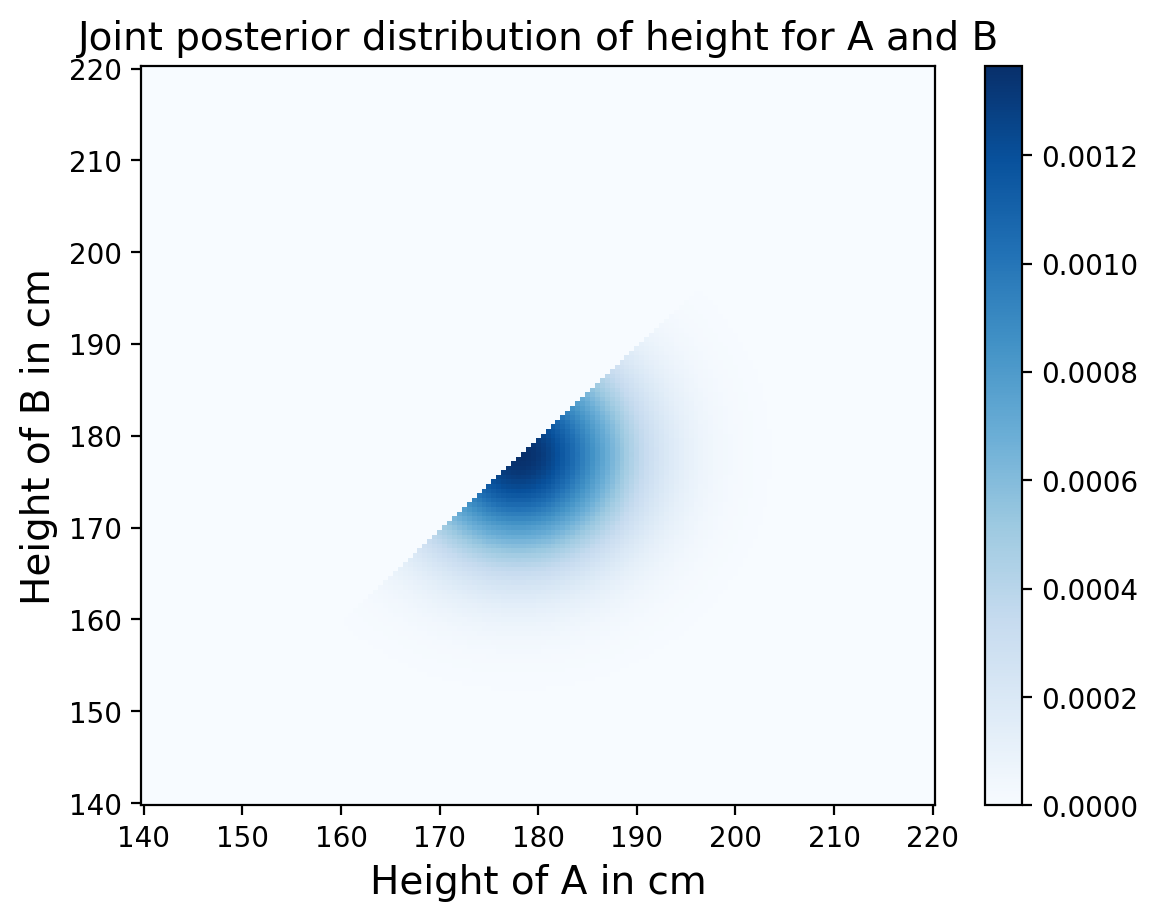

In [9]:
plt.pcolormesh(posterior.columns, posterior.index, posterior, cmap='Blues')
plt.colorbar()
plt.xlabel('Height of A in cm', size=14)
plt.ylabel('Height of B in cm', size=14)
plt.title('Joint posterior distribution of height for A and B', size=14);

### Marginal Distribution

Finally, we want to compute the posterior distribution of heights for person A. All that means is we need to calculate the marginal distribution for A from the joint posterior!

Quick reminder: the mariginal is named after the sum we might see in the margin of a notebook. When looking at joint probabilities, the marginal for one variable requires summing over the other.

In [10]:
# sum over the rows of the joint posterior
marginal_A = posterior.sum(axis=0)

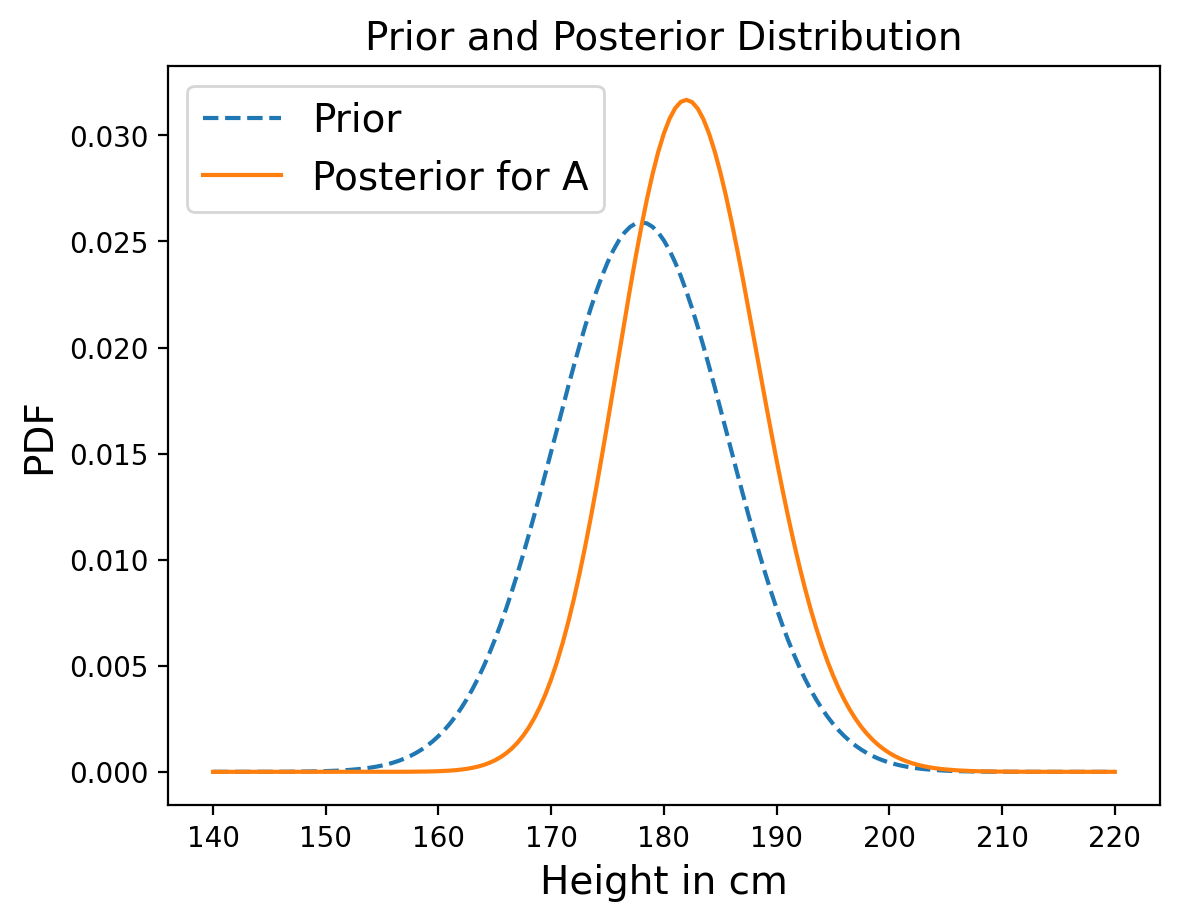

In [11]:
fig, ax = plt.subplots()
p_dist.plot(ax=ax, style='--')
marginal_A.plot(ax=ax)
ax.legend(['Prior', 'Posterior for A'], fontsize = 14, loc = 'best')
plt.title('Prior and Posterior Distribution', size=14)
plt.xlabel('Height in cm', size=14)
plt.ylabel('PDF', size=14);

And now we have the distribution of heights for person A, only given the knowledge that they are taller than some random person B! 

We can quickly calculate the MMSE height to fully answer the question:

In [12]:
sum(marginal_A.index*marginal_A)

182.42454600578696

Also notice that the posterior is slightly narrower than the prior, which makes sense since it's based on an observation.

### Conditional Posteriors

We can actually take this analysis one step further. Suppose we now measure A and find that he is 170 cm tall. What does that tell us about the height of B?

In the joint distribution, each column corresponds to a possible height for A. We can select the column that corresponds to height 170 cm from our posterior distribuion:

In [13]:
column_170 = posterior[170]

The result is a vector that represents possible heights for B and their relative likelihoods. These likelihoods are not normalized, but we can normalize them:

In [14]:
column_170 = column_170/sum(column_170)

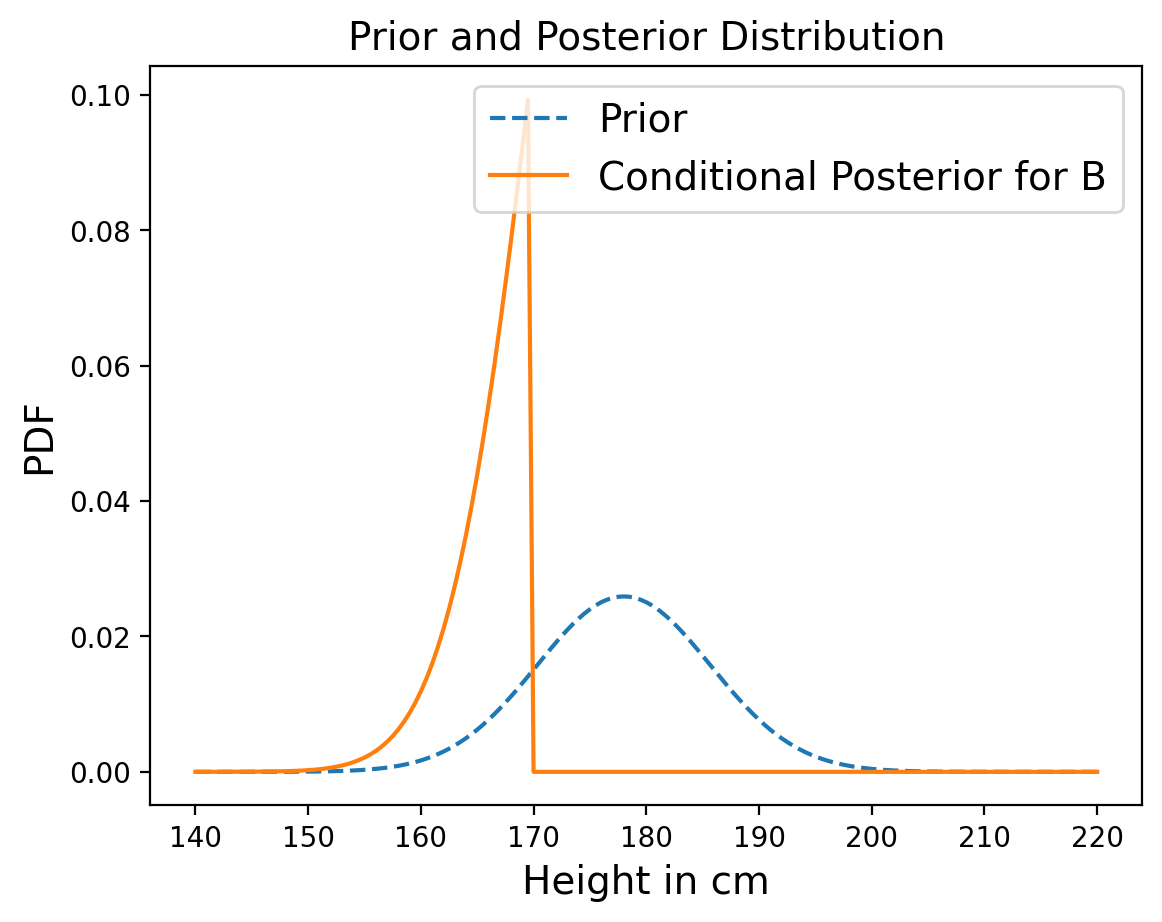

In [15]:
fig, ax = plt.subplots()
p_dist.plot(ax=ax, style='--')
column_170.plot(ax=ax)
ax.legend(['Prior', 'Conditional Posterior for B'], fontsize = 14, loc = 'best')
plt.title('Prior and Posterior Distribution', size=14)
plt.xlabel('Height in cm', size=14)
plt.ylabel('PDF', size=14);

## Dependence and Independence

When we constructed the joint prior distribution, we noted that the heights of A and B were independent, which means that knowing one of them provides no information about the other. In other words, the conditional probability is the same as the unconditional probability.

But in the posterior distribution, A and B are not independent. If we know that A is taller than B, and we know how tall A is, that gives us information about B.

The conditional distribution we just computed demonstrates this dependence.